In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO, Phylo
import dendropy

%matplotlib inline
pd.options.display.precision = 3

In [2]:
# load responses-staph.csv - the result of antibiotic resistence of staphylococcus
# 125 * 1
resp = pd.read_csv('../data/staph/responses-staph.csv')

# load core_gene_alignment-narsa.aln - the gene sequence of staphylococcus
# 125 * 983088
src = SeqIO.parse('../data/staph/core_gene_alignment-narsa.aln', 'fasta')
data = [(record.id, record.seq._data.upper()) for record in src]
seq = pd.DataFrame(data=data, columns=['ids', 'sequence'])

# merge DataFrames of two files into one DataFrame
records = pd.merge(seq, resp, on='ids')

records['resp'].value_counts()

# calculate missing number and percentage of nucleotides of each sequence

seq_len = np.mean(records['sequence'].apply(len))
records['missing'] = records['sequence'].apply(lambda seq: Counter(seq)['-'])

records['missing_percentage'] = records['missing'] / seq_len * 100
records

,ids,sequence,resp,missing,missing_percentage
0,NRS001,ATGAACATTTATGATGAATATAGAAGTTATTTAATAGAAGAACTGG...,False,2511,0.255
1,NRS002,----------------------------------------------...,False,25278,2.571
2,NRS003,ATGAACATTTATGATGAATATAGAAGTTATTTAATAGAAGAACTGG...,False,48213,4.904
3,NRS021,ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...,False,2442,0.248
4,NRS022,ATGAACATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...,False,3885,0.395
...,...,...,...,...,...
120,NRS272,ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...,False,66885,6.804
121,NRS275,ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...,False,8052,0.819
122,NRS383,ATGAACATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...,False,3003,0.305
123,NRS386,ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...,True,2790,0.284


In [3]:
# calculate true/false percentage of the class
resp_counts = records['resp'].value_counts()
counts = pd.DataFrame({'unknown': resp_counts})
counts.div(counts.sum() / 100)

,unknown
False,83.065
True,16.935


In [4]:
# group genes in the sequence by three (into condons)
# and count different number of condons across all samples
condonify = lambda seq: [seq[i:i+3] for i in range(0, len(seq), 3)]
sequence_condonified = records['sequence'].apply(condonify)
c = Counter()
for condons in sequence_condonified:
    c.update(Counter(condons))

In [5]:
len(c.keys())

116

In [6]:
c.keys()

dict_keys(['ATG', 'AAC', 'ATT', 'TAT', 'GAT', 'GAA', 'AGA', 'AGT', 'TTA', 'ATA', 'CTG', 'TGT', 'CTC', 'ACA', 'CAA', 'AAA', 'AAT', 'GAC', 'ACT', 'GCA', 'TAC', 'GTG', 'CTA', 'GCG', 'TCA', 'CAT', 'GGA', 'TTC', 'GAG', 'TTT', 'TTG', 'CGT', 'AAG', 'GTT', 'GGG', 'AGG', 'CCT', 'GCT', 'GGT', 'CAC', 'ATC', 'ACG', 'TGG', 'GGC', 'TCG', 'GTA', 'GTC', 'TAG', 'CGA', 'TGC', 'CCA', 'CAG', 'ACC', 'CTT', 'TCT', 'AGC', 'TCC', 'TAA', 'CCG', 'CCC', 'GCC', 'CGC', 'CGG', '---', 'AA-', '--T', '--A', 'TGA', 'GA-', 'AG-', '-AT', 'G--', '-GT', '--G', '-AA', 'T-A', '-TT', 'A-T', 'A--', 'CG-', 'T--', '-AC', '-TA', 'TA-', '--C', 'CA-', 'G-A', 'C-A', 'GC-', 'AT-', 'TG-', 'C--', 'CC-', 'A-G', '-GA', '-CA', '-GG', '-TG', 'GT-', 'CT-', 'AC-', 'TC-', 'C-T', 'A-C', '-CG', '-AG', 'TT-', '-CC', 'GG-', 'G-T', 'NNN', 'NTT', '-A-', '-GC', 'A-A', 'T-G'])

In [7]:
# verify the result
sum(c.values()) * 3 / 125 == seq_len

True

# Distance matrix & Phylogenetic tree

In [4]:
def diff(seq1, seq2):
    '''Count the number of different loci between two sequences'''
    diff_count = 0
    for n1, n2 in zip(seq1, seq2):
        if n1 != n2:
            diff_count += 1
    return diff_count

In [9]:
# build the distance matrix
dist_mat = np.zeros((records.shape[0], records.shape[0]), dtype='i4')
for i in range(records.shape[0]):
    for j in range(i, records.shape[0]):
        d = diff(records['sequence'][i], records['sequence'][j])
        dist_mat[i, j] = d
        dist_mat[j, i] = d

In [10]:
dist_mat = pd.DataFrame(dist_mat, index=records['ids'], columns=records['ids'])
dist_mat[dist_mat==0] = np.inf
dist_mat.to_csv('../data/staph/staph_dist_mat.csv')

In [11]:
def upgma(df, copy=True):
    '''Build a phylogenetic tree (in newick format) using UPGMA based on a distance matrix'''
    if copy:
        df = df.copy()
    while df.size > 1:
        mask = (df == df.min().min())     # where is the minimum
        row = mask.any(axis=1)            # which row
        pos = df[row].idxmin(axis=1)      # which column
        for i in range(0, pos.size//2):
            a = pos.index[i]
            b = pos[i]
            # combine the row and column of one with the other
            result = (df.loc[a] + df.loc[b]) / 2
            df.loc[a] = result
            df.loc[:, a] = result
            # drop row and coulmn of the other
            df = df.drop(b, axis=0).drop(b, axis=1)
            # rename index and column name of the combined sample
            df.rename(mapper=lambda s: s if s != a else '({},{})'.format(a, b), axis=0, inplace=True)
            df.rename(mapper=lambda s: s if s != a else '({},{})'.format(a, b), axis=1, inplace=True)
    return df.index[0]+';'

In [25]:
%time tree_str = upgma(dist_mat)
with open('../data/staph/staph_tree.dnd', 'w') as dnd:
    dnd.write(tree_str)
tree_str

CPU times: user 2 s, sys: 0 ns, total: 2 s
Wall time: 1.99 s


'((((((((((((((((((((((((((((((((NRS001,(NRS051,NRS387)),NRS049),NRS074),NRS240),NRS110),NRS149),NRS188),(((((NRS072,NRS248),NRS226),((NRS105,(NRS220,NRS224)),((NRS175,NRS386),NRS255))),((NRS164,NRS233),NRS183)),((NRS187,NRS227),NRS260))),((((((((((((((((NRS021,NRS119),((NRS039,NRS100),((NRS198,NRS202),NRS254))),(NRS106,NRS152)),NRS214),NRS172),NRS211),NRS036),NRS073),NRS027),NRS249),NRS145),NRS114),NRS107),NRS218),NRS201),NRS275)),NRS102),(NRS054,NRS063)),NRS108),NRS064),NRS035),(NRS209,NRS268)),NRS262),((((((NRS113,NRS170),(((NRS148,NRS205),NRS199),(NRS241,(NRS243,NRS245)))),(((NRS185,(NRS215,((NRS217,NRS239),NRS237))),NRS230),NRS266)),NRS253),(((((NRS157,NRS161),NRS167),NRS235),NRS203),NRS231)),(NRS225,NRS242))),NRS194),(NRS002,NRS070)),NRS256),((((((NRS022,(NRS109,NRS169)),NRS236),NRS168),NRS103),NRS111),(((((((NRS029,((((((((((NRS071,(NRS112,NRS162)),NRS383),NRS207),((NRS210,NRS212),NRS213)),((NRS177,NRS264),NRS189)),NRS216),NRS219),NRS222),NRS104),NRS252)),NRS246),NRS247),NRS204)

In [26]:
# visualize tree with dendropy
tree = dendropy.Tree.get(data=tree_str, schema='newick')
print(tree.as_ascii_plot())

                                                                    /--- NRS001
                                                                  /-+          
                                                                  | | /- NRS051
                                                                 /+ \-+        
                                                                 ||   \- NRS387
                                                               /-+|            
                                                               | |\----- NRS049
                                                             /-+ |             
                                                             | | \------ NRS074
                                                            /+ |               
                                                            || \-------- NRS240
                                                          /-+|                 
                                        

In [27]:
# format the ascii tree with labels
tree_ascii = tree.as_ascii_plot()
for i, record in records.iterrows():
    tree_ascii = tree_ascii.replace(record['ids'],
                                    '{id__}: {unknown}'.format(
                                        id__=record['ids'], unknown=record['resp']),
                                    1)
print(tree_ascii)

                                                                    /--- NRS001: False
                                                                  /-+          
                                                                  | | /- NRS051: False
                                                                 /+ \-+        
                                                                 ||   \- NRS387: False
                                                               /-+|            
                                                               | |\----- NRS049: False
                                                             /-+ |             
                                                             | | \------ NRS074: False
                                                            /+ |               
                                                            || \-------- NRS240: True
                                                          /-+|                 

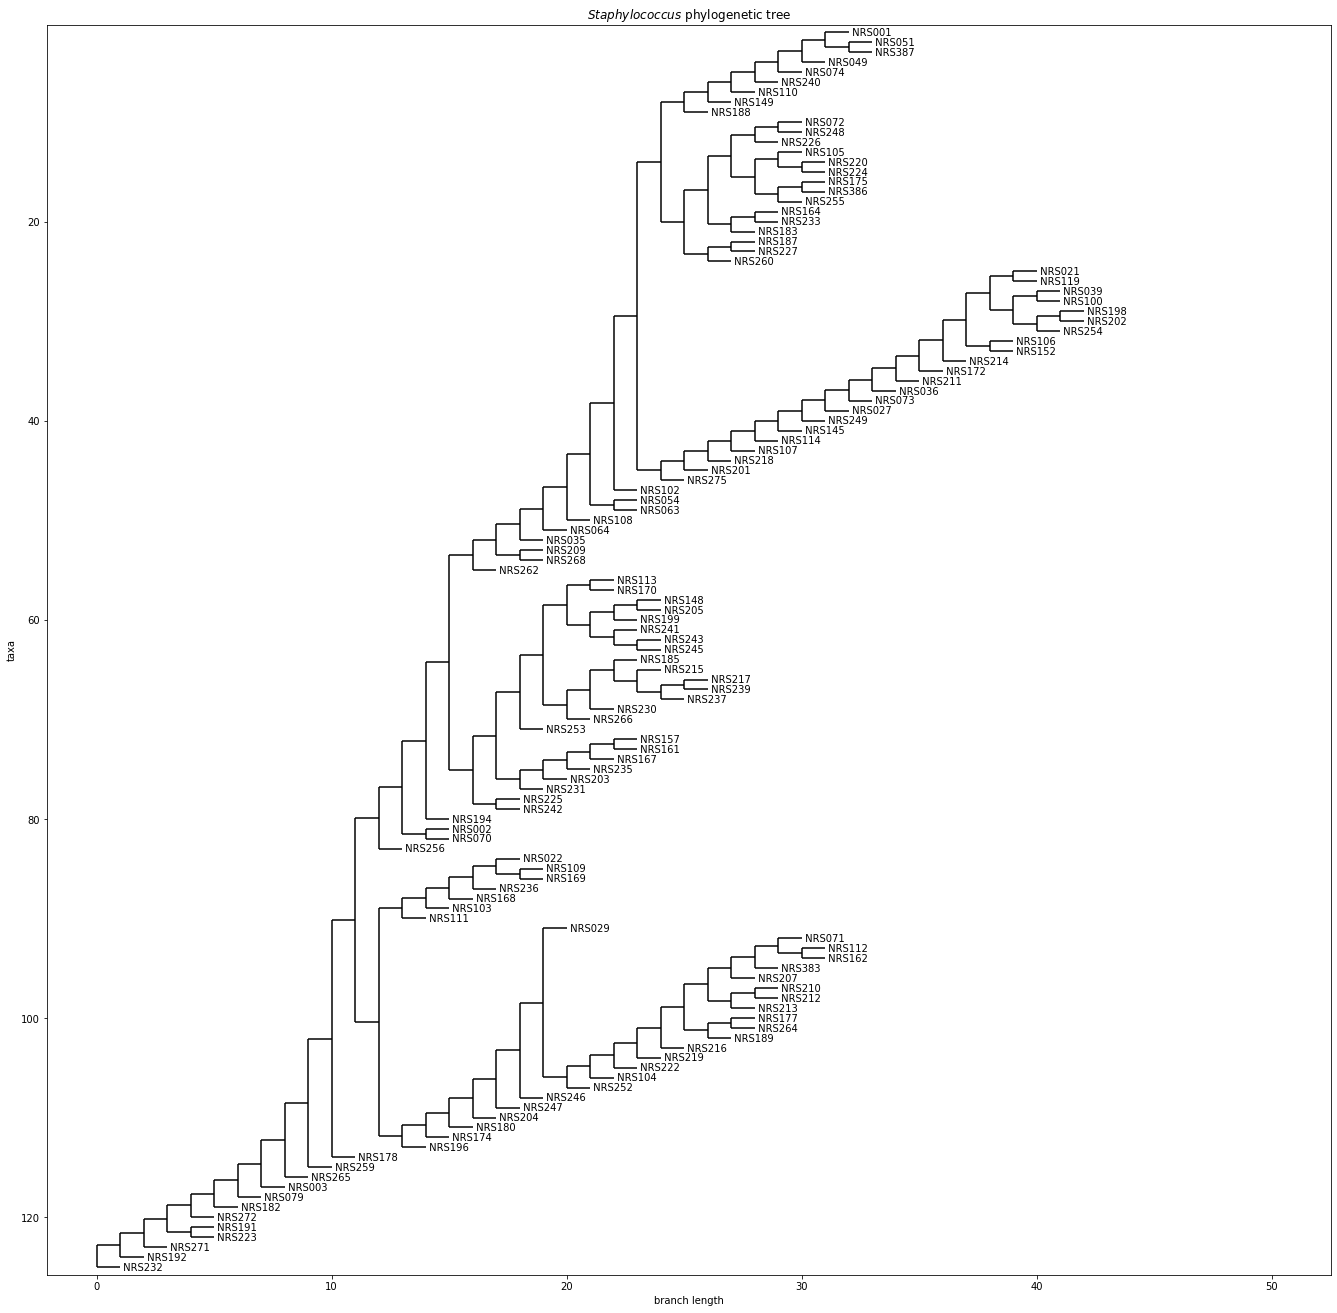

In [30]:
# visualize tree with biopython and matplotlib
tree = Phylo.read('../data/staph/staph_tree.dnd', format='newick')
plt.figure(figsize=(23, 23))
plt.title('$Staphylococcus$ phylogenetic tree')
Phylo.draw(tree, axes=plt.gca())

# Experiment

In [18]:
sequence = records['sequence']
sequence

0      ATGAACATTTATGATGAATATAGAAGTTATTTAATAGAAGAACTGG...
1      ----------------------------------------------...
2      ATGAACATTTATGATGAATATAGAAGTTATTTAATAGAAGAACTGG...
3      ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...
4      ATGAACATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...
                             ...                        
120    ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...
121    ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...
122    ATGAACATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...
123    ATGAAAATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...
124    ATGAACATTTATGATGAATATAGAAGTTATTTAATAGAAGAACTGG...
Name: sequence, Length: 125, dtype: object

In [19]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()

In [20]:
forward = str.maketrans('-ACTGN', '012345')
backward = str.maketrans('012345', '-ACTGN')
def transformation(str):
    return [int(i) for i in str.translate(forward)]

In [21]:
from collections import Counter

for (i, seq) in enumerate(sequence):
    print(i, Counter(seq))

0 Counter({'A': 345986, 'T': 294496, 'G': 192941, 'C': 147154, '-': 2511})
1 Counter({'A': 337511, 'T': 287275, 'G': 189106, 'C': 143918, '-': 25278})
2 Counter({'A': 329401, 'T': 279828, 'G': 184938, 'C': 140708, '-': 48213})
3 Counter({'A': 345979, 'T': 294475, 'G': 192959, 'C': 147233, '-': 2442})
4 Counter({'A': 345511, 'T': 294082, 'G': 192719, 'C': 146891, '-': 3885})
5 Counter({'A': 345660, 'T': 294132, 'G': 192816, 'C': 147105, '-': 3375})
6 Counter({'A': 343519, 'T': 292212, 'G': 191690, 'C': 146262, '-': 9405})
7 Counter({'A': 340683, 'T': 289818, 'G': 190408, 'C': 145157, '-': 17022})
8 Counter({'A': 345863, 'T': 294299, 'G': 192890, 'C': 147153, '-': 2883})
9 Counter({'A': 346022, 'T': 294459, 'G': 192979, 'C': 147225, '-': 2403})
10 Counter({'A': 345896, 'T': 294441, 'G': 192901, 'C': 147120, '-': 2730})
11 Counter({'A': 346018, 'T': 294491, 'G': 192954, 'C': 147156, '-': 2469})
12 Counter({'A': 343034, 'T': 291567, 'G': 191407, 'C': 146010, '-': 11070})
13 Counter({'A': 3

113 Counter({'A': 344507, 'T': 293082, 'G': 192302, 'C': 146690, '-': 6507})
114 Counter({'A': 342320, 'T': 291156, 'G': 190768, 'C': 145533, '-': 13311})
115 Counter({'A': 345827, 'T': 294283, 'G': 192884, 'C': 147118, '-': 2976})
116 Counter({'A': 333404, 'T': 283573, 'G': 186756, 'C': 142239, '-': 37116})
117 Counter({'A': 342969, 'T': 292209, 'G': 191551, 'C': 146018, '-': 10341})
118 Counter({'A': 341953, 'T': 291024, 'G': 191209, 'C': 145765, '-': 13137})
119 Counter({'A': 313368, 'T': 266590, 'G': 176748, 'C': 134675, '-': 91707})
120 Counter({'A': 322138, 'T': 274214, 'G': 181594, 'C': 138257, '-': 66885})
121 Counter({'A': 343824, 'T': 292775, 'G': 192026, 'C': 146411, '-': 8052})
122 Counter({'A': 345856, 'T': 294253, 'G': 192840, 'C': 147136, '-': 3003})
123 Counter({'A': 345875, 'T': 294369, 'G': 192915, 'C': 147139, '-': 2790})
124 Counter({'A': 346018, 'T': 294490, 'G': 192942, 'C': 147151, '-': 2487})


In [26]:
Counter(records.iloc[46].sequence)

Counter({'A': 345642,
         'T': 294225,
         'G': 192720,
         'C': 146966,
         '-': 3525,
         'N': 10})

In [27]:
records.iloc[46]

ids                                                              NRS169
sequence              ATGAACATTTATGATGAATATAGAAGTTATGTAATAGAAGAACTGG...
resp                                                               True
missing                                                            3525
missing_percentage                                                0.359
Name: 46, dtype: object

In [32]:
%time tran = selector.fit_transform(sequence.apply(transformation).to_list())

CPU times: user 46.7 s, sys: 936 ms, total: 47.7 s
Wall time: 47.7 s


In [33]:
len(tran[0])

496218